# Признаки, основанные на временных данных

In [16]:
import pandas as pd
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

PATH_TO_DATA = 'data/'
train = pd.read_csv(os.path.join(PATH_TO_DATA, 'onetwotrip_challenge_train.csv'))
test = pd.read_csv(os.path.join(PATH_TO_DATA, 'onetwotrip_challenge_test.csv'))

Выберем одного пользователя с наибольшим количеством покупок и возьмем только необходимые временные признаки. Поменяем названия для удобства и отсортируем по field4 (номер покупки).

In [17]:
user_id = train['userid'].value_counts().index[0]

user = train[train['userid'] == user_id]
user.sort_values(by=['field4'], inplace=True)

user_date = user[['field2', 'field3', 'field18', 'field20', 'field0', 'field16']]
user_date.columns = ['month_buy', 'month_fly', 'weekday_buy', 'weekday_fly', 'delta_buy_buy', 'delta_fly_buy']
user_date.head(10)

,month_buy,month_fly,weekday_buy,weekday_fly,delta_buy_buy,delta_fly_buy
162877,6,6,2,3,0,1
125446,6,6,2,3,0,1
39421,6,6,2,3,0,1
174386,6,6,4,1,16,4
83155,6,6,4,2,0,5
186621,6,6,5,3,1,5
102930,6,6,5,6,0,8
189031,6,6,1,4,3,3
177676,6,6,1,5,0,4
74136,6,7,1,2,0,8


- delta_buy_buy - количество дней прошедших с предыдущей покупки
- delta_fly_buy - количество дней с момента покупки до момента вылета

Попробуем извлечь из этих признаков больше информации.  

Далее буду использовать следующие сокращения:
- $\Delta^{bb}_i$ - delta_buy_buy[ i ]
- $\Delta^{fb}_i$ - delta_fly_buy[ i ]
- $\Delta^{fb_0}_i$ - delta_fly[ i ],  количество дней с момента первой покупки до n-ого полета


Мы можем вычислить количество дней с момента первой покупки до n-ого полета:

$\Delta^{fb_0}_0 = \Delta^{fb}_0$  
$\Delta^{fb_0}_1 = \Delta^{fb}_1 + \Delta^{bb}_1$  
$\Delta^{fb_0}_2 = \Delta^{fb}_2 + \Delta^{bb}_1 + \Delta^{bb}_2$  
...  
$\Delta^{fb_0}_i = \Delta^{fb}_i + \sum_{1}^{i}\Delta^{bb}_i$

![delta.jpg](delta.jpg)

Для нахождения delta_fly посчитаем кумулятивную сумму delta_buy_buy

In [19]:
user_date['cumsum_delta_buy_buy'] = np.cumsum(user_date['delta_buy_buy'])
user_date['delta_fly'] = user_date['cumsum_delta_buy_buy'] + user_date['delta_fly_buy']

In [27]:
user_date[['delta_buy_buy', 'cumsum_delta_buy_buy', 'delta_fly_buy','delta_fly']].head(10)

,delta_buy_buy,cumsum_delta_buy_buy,delta_fly_buy,delta_fly
162877,0,0,1,1
125446,0,0,1,1
39421,0,0,1,1
174386,16,16,4,20
83155,0,16,5,21
186621,1,17,5,22
102930,0,17,8,25
189031,3,20,3,23
177676,0,20,4,24
74136,0,20,8,28


Теперь мы можем найти дельту между датой покупаемого рейса и предыдущего рейса

In [42]:
delta_fly = np.asarray(user_date['delta_fly'])
delta_fly.sort()
delta_ff = np.append(0, delta_fly[1:] - delta_fly[:-1])
delta_ff_dict = dict(zip(delta_fly, delta_ff))
user_date['delta_fly_fly'] = user_date['delta_fly'].apply(lambda x: delta_ff_dict[x])

In [44]:
user_date.head(10)

,month_buy,month_fly,weekday_buy,weekday_fly,delta_buy_buy,delta_fly_buy,cumsum_delta_buy_buy,delta_fly,delta_fly_fly
162877,6,6,2,3,0,1,0,1,0
125446,6,6,2,3,0,1,0,1,0
39421,6,6,2,3,0,1,0,1,0
174386,6,6,4,1,16,4,16,20,19
83155,6,6,4,2,0,5,16,21,1
186621,6,6,5,3,1,5,17,22,0
102930,6,6,5,6,0,8,17,22,0
189031,6,6,1,4,3,3,20,23,0
177676,6,6,1,5,0,4,20,23,0
74136,6,7,1,2,0,8,20,24,1


Теперь мы знаем, сколько еще покупок было сделано на такую же дату вылета.  
И можем, например, посчитать, сколько покупок было сделано в этот день, следующий и предыдущий.

In [48]:
val_counts = user_date['delta_fly'].value_counts()
unique = val_counts.index

new_val_counts = dict()
for i in unique:
    new_val_counts[i] = val_counts.get(i - 1, 0) + val_counts.get(i, 0) + val_counts.get(i + 1, 0)
    
user_date['quantity_buy_one_day'] = user_date['delta_fly'].apply(lambda x: val_counts[x])
user_date['quantity_buy_one_day_3'] = user_date['delta_fly'].apply(lambda x: new_val_counts[x])

In [49]:
user_date.head(10)

,month_buy,month_fly,weekday_buy,weekday_fly,delta_buy_buy,delta_fly_buy,cumsum_delta_buy_buy,delta_fly,delta_fly_fly,quantity_buy_one_day,quantity_buy_one_day_3
162877,6,6,2,3,0,1,0,1,0,3,3
125446,6,6,2,3,0,1,0,1,0,3,3
39421,6,6,2,3,0,1,0,1,0,3,3
174386,6,6,4,1,16,4,16,20,19,1,2
83155,6,6,4,2,0,5,16,21,1,1,4
186621,6,6,5,3,1,5,17,22,0,2,5
102930,6,6,5,6,0,8,17,22,0,2,5
189031,6,6,1,4,3,3,20,23,0,2,5
177676,6,6,1,5,0,4,20,23,0,2,5
74136,6,7,1,2,0,8,20,24,1,1,4


С помощью этого признака мы хотим отлавливать события, когда человек покупает несколько билетов. Но в теории может быть, что человек часто делает несколько покупок на один рейс. Поэтому введем еще один признак, который будет учитывать среднее количество билетов на один день.

In [50]:
mean_count = np.asarray(list(new_val_counts.values())).mean()
k = len(new_val_counts)
mean_count = (mean_count * k + 1 * 5) / (k + 5)

user_date['quantity_buy_one_day_averaged'] = user_date['delta_fly'].apply(lambda x: new_val_counts[x]) / mean_count

Проверим полученные фичи на выборке с людьми, у которых больше трех покупок. (Меньше будет долго считаться)

In [55]:
flight_quantity = dict(train['userid'].value_counts())
train['buy_quantity'] = train['userid'].apply(lambda x: flight_quantity[x])

train_part = train[(train['buy_quantity'] > 3)]
train_part.shape

(55318, 44)

In [68]:
%%time

users_id = np.unique(train_part['userid'])

train_new = pd.DataFrame()
for user_id in users_id:
    user = train[train['userid'] == user_id]
    user.sort_values(by=['field4'], inplace=True)
    
    user.rename(columns={'field0': 'delta_buy_buy', 'field2': 'month_buy', 'field3': 'month_fly', 
                    'field18': 'weekday_buy', 'field20': 'weekday_fly', 'field16': 'delta_fly_buy'}, inplace=True)
    
    user['cumsum_delta_buy_buy'] = np.cumsum(user['delta_buy_buy'])
    user['delta_fly'] = user['cumsum_delta_buy_buy'] + user['delta_fly_buy']
    
    val_counts = user['delta_fly'].value_counts()
    unique = val_counts.index
    new_val_counts = dict()
    for i in unique:
        new_val_counts[i] = val_counts.get(i - 1, 0) + val_counts.get(i, 0) + val_counts.get(i + 1, 0)
    
    user['quantity_buy_one_day'] = user['delta_fly'].apply(lambda x: val_counts[x])
    user['quantity_buy_one_day_3'] = user['delta_fly'].apply(lambda x: new_val_counts[x])
    
    mean_count = np.asarray(list(new_val_counts.values())).mean()
    user['mean_quantity_buy_one_day'] = mean_count
    k = len(new_val_counts)
    mean_count = (mean_count * k + 1 * 5) / (k + 5)
    
    user['quantity_buy_one_day_averaged'] = user['delta_fly'].apply(lambda x: new_val_counts[x]) / mean_count
    
    delta_fly = np.asarray(user['delta_fly'])
    delta_fly.sort()
    delta_ff = np.append(0, delta_fly[1:] - delta_fly[:-1])
    delta_ff_dict = dict(zip(delta_fly, delta_ff))
    user['delta_fly_fly'] = user['delta_fly'].apply(lambda x: delta_ff_dict[x])

    train_new = pd.concat([train_new, user])

CPU times: user 21min 20s, sys: 2min 34s, total: 23min 55s
Wall time: 6min 38s


In [69]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (df[var].min(), df[var].max()))
    facet.add_legend()
    plt.show()

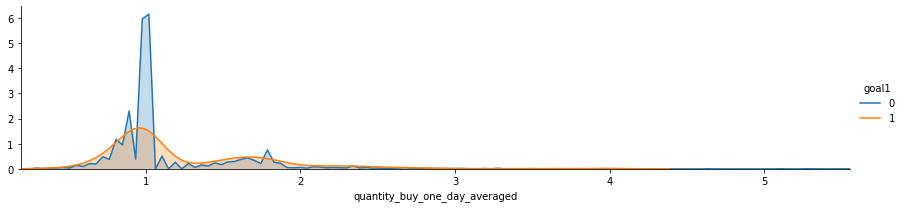

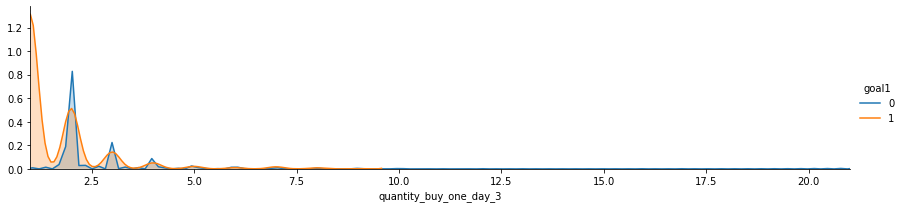

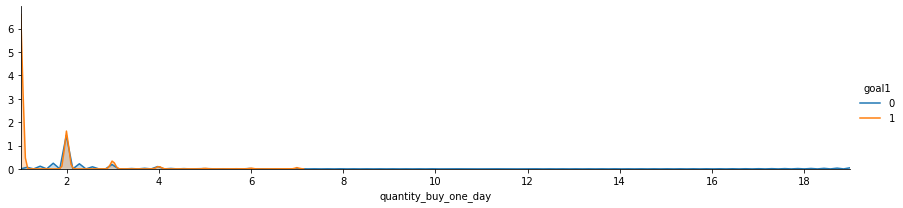

In [70]:
plot_distribution(train_new, 'quantity_buy_one_day_averaged', 'goal1')
plot_distribution(train_new, 'quantity_buy_one_day_3', 'goal1')
plot_distribution(train_new, 'quantity_buy_one_day', 'goal1')

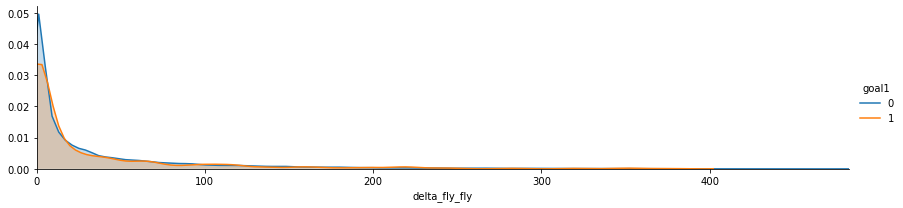

In [76]:
plot_distribution(train_new, 'delta_fly_fly', 'goal1')

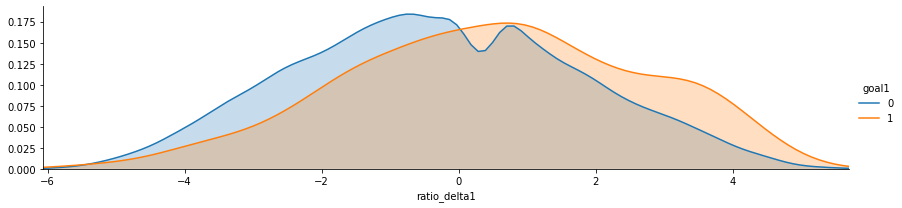

In [72]:
train_new['ratio_delta1'] = (np.log(train_new['delta_fly_buy'] + 1) - np.log(train_new['delta_fly_fly'] + 1))
plot_distribution(train_new, 'ratio_delta1', 'goal1')

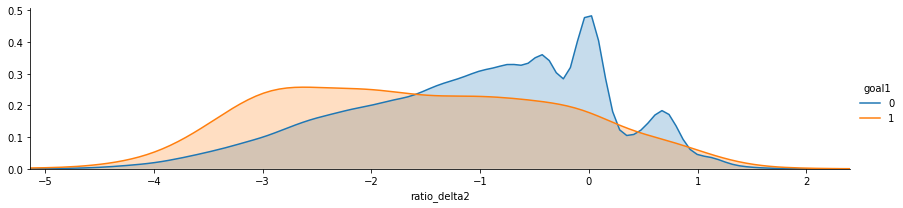

In [74]:
train_new['ratio_delta2'] = (np.log(train_new['quantity_buy_one_day'] + 1) - np.log(train_new['delta_fly_buy'] + 1))
plot_distribution(train_new, 'ratio_delta2', 'goal1')

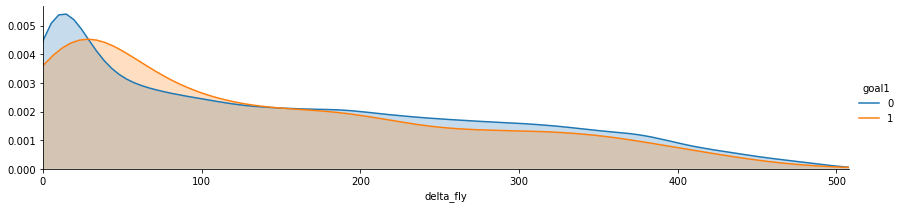

In [75]:
plot_distribution(train_new, 'delta_fly', 'goal1')